# Webinar n°2: Pyleecan Advanced - Part 2: SciDataTool

This notebook is the support of the second out of three webinars organized by the association [Green Forge Coop](https://www.linkedin.com/company/greenforgecoop/about/) and the UNICAS University. 

The webinars schedule is:
- Friday 16th October 15h-17h (GMT+2): How to use pyleecan (basics)? Pyleecan basics, call of FEMM, use of the GUI
- Friday 30th October 15h-17h (GMT+1): How to use pyleecan (advanced)? Optimization tools, meshing, plot commands
- Friday 6th November 15h-17h (GMT+1): How to contribute to pyleecan? Github projects, Object Oriented Programming

Speakers: Pierre Bonneel, Hélène Toubin, Raphaël Pile from EOMYS.

This webinar will be recorded and the video will be shared on [pyleecan.org](https://pyleecan.org/tutorials.html)

To use this notebook please:
- Install Anaconda
- In Anaconda Prompt run the command "pip install pyleecan"
- Install the latest version of [femm](http://www.femm.info/wiki/Download) (windows only)
- In Anaconda Navigator, lanch Jupyter Notebook
- Jupyter Notebook should open a tab in your web brower, select this notebook to open it

To check if everything is correctly set, please run the following cell (WARNING: the webinar use pyleecan 1.0.2 and SciDataTool 1.1.5):

Pyleecan version: 1.0.2


<IPython.core.display.Javascript object>


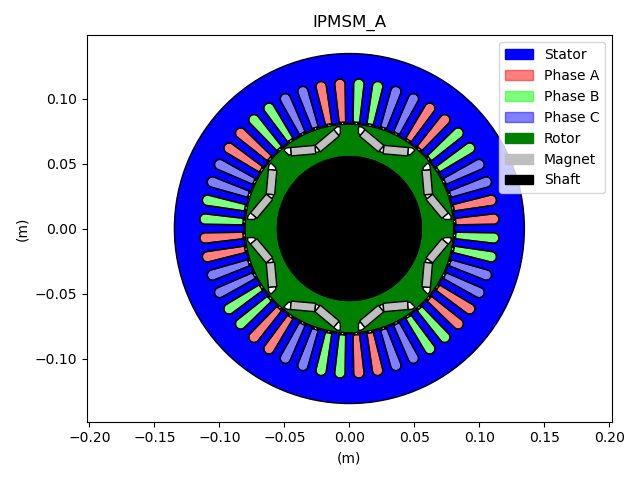

In [1]:
%matplotlib notebook

# Print version of all packages
import pyleecan
print("Pyleecan version: "+pyleecan.__version__)

# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

IPMSM_A = load(join(DATA_DIR, "Machine", "IPMSM_A.json"))
IPMSM_A.plot()

# Check FEMM installation
from pyleecan.Classes._FEMMHandler import FEMMHandler

femm = FEMMHandler()
femm.openfemm(0)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d

## 1) Pyleecan simulation

To demonstrate the capabilities and the use of the SciDataTool objects, two simulations are launched with FEMM: with imposed currents and in open-circuit. The simulations use periodicity and parallelization to reduce execution time.

In [4]:
from os import chdir
chdir('..')

# Import Pyleecan modules
from numpy import exp, sqrt, pi
from os.path import join
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.Output import Output
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

# Load the machine
IPMSM_A = load(join(DATA_DIR, "Machine", "IPMSM_A.json"))

# Simulation initialization
simu = Simu1(name="FEMM_periodicity", machine=IPMSM_A)

# Definition of the enforced output of the electrical module
simu.input = InputCurrent(
    Na_tot=252 * 8,
    Nt_tot=50 * 8,
    N0=1000,
)
# Set Id/Iq according to I0/Phi0
simu.input.set_Id_Iq(I0=250 / sqrt(2), Phi0=140*pi/180)

# Definition of the magnetic simulation: with periodicity
simu.mag = MagFEMM(is_periodicity_a=True, is_periodicity_t=True, nb_worker=4)
simu.force = ForceMT(is_periodicity_a=True, is_periodicity_t=True)

# Definition of the open-circuit simulation
simu2 = simu.copy()
simu2.input.Id_ref = 0
simu2.input.Iq_ref = 0

# Run simulations
out = simu.run()
out2 = simu2.run()

2020-10-29 13:44:10,606-INFO-Pyleecan.Simulation: Starting Magnetic module
2020-10-29 13:44:34,369-INFO-Pyleecan.Simulation: Starting Magnetic module


## 2) How to extract data

Many output data are stored in **SciDataTool** formats. Here, we take for example the torque, for which the periodic part is stored along with its time axis.

To access data stored in **SciDataTool** objects, we use `get_along` methods as seen previously:

In [5]:
print(out.mag.Tem.get_along("time"))

{'time': array([0.     , 0.00015, 0.0003 , 0.00045, 0.0006 , 0.00075, 0.0009 ,
       0.00105, 0.0012 , 0.00135, 0.0015 , 0.00165, 0.0018 , 0.00195,
       0.0021 , 0.00225, 0.0024 , 0.00255, 0.0027 , 0.00285, 0.003  ,
       0.00315, 0.0033 , 0.00345, 0.0036 , 0.00375, 0.0039 , 0.00405,
       0.0042 , 0.00435, 0.0045 , 0.00465, 0.0048 , 0.00495, 0.0051 ,
       0.00525, 0.0054 , 0.00555, 0.0057 , 0.00585, 0.006  , 0.00615,
       0.0063 , 0.00645, 0.0066 , 0.00675, 0.0069 , 0.00705, 0.0072 ,
       0.00735, 0.0075 , 0.00765, 0.0078 , 0.00795, 0.0081 , 0.00825,
       0.0084 , 0.00855, 0.0087 , 0.00885, 0.009  , 0.00915, 0.0093 ,
       0.00945, 0.0096 , 0.00975, 0.0099 , 0.01005, 0.0102 , 0.01035,
       0.0105 , 0.01065, 0.0108 , 0.01095, 0.0111 , 0.01125, 0.0114 ,
       0.01155, 0.0117 , 0.01185, 0.012  , 0.01215, 0.0123 , 0.01245,
       0.0126 , 0.01275, 0.0129 , 0.01305, 0.0132 , 0.01335, 0.0135 ,
       0.01365, 0.0138 , 0.01395, 0.0141 , 0.01425, 0.0144 , 0.01455,
       0.01

By default, the method reconstructs the whole periodic signal. To extract only the periodic part, which can be useful in computations, use `oneperiod`, `antiperiod` or `smallestperiod`:

In [6]:
print(out.mag.Tem.get_along("time[smallestperiod]"))

{'time': array([0.     , 0.00015, 0.0003 , 0.00045, 0.0006 , 0.00075, 0.0009 ,
       0.00105, 0.0012 , 0.00135, 0.0015 , 0.00165, 0.0018 , 0.00195,
       0.0021 , 0.00225, 0.0024 , 0.00255, 0.0027 , 0.00285, 0.003  ,
       0.00315, 0.0033 , 0.00345, 0.0036 , 0.00375, 0.0039 , 0.00405,
       0.0042 , 0.00435, 0.0045 , 0.00465, 0.0048 , 0.00495, 0.0051 ,
       0.00525, 0.0054 , 0.00555, 0.0057 , 0.00585, 0.006  , 0.00615,
       0.0063 , 0.00645, 0.0066 , 0.00675, 0.0069 , 0.00705, 0.0072 ,
       0.00735]), 'T_{em}': array([393.44827714, 404.36360918, 389.37819159, 362.10959106,
       334.66672809, 320.27090898, 317.9358013 , 334.48147546,
       360.15434615, 376.68763127, 371.50287769, 353.86160791,
       333.98647756, 324.43521333, 327.18938733, 343.50581314,
       374.25966941, 399.27164103, 400.7696417 , 381.04355235,
       352.51314762, 329.88493999, 320.27419165, 321.96423146,
       343.04990355, 366.35838223, 376.23735048, 366.05021371,
       346.27106515, 329.1151947

## 3) How to plot data

**Pyleecan** has generic built-in plot commands, which allow to easily plot any field stored in a **SciDataTool** object:

- `plot_2D`, `plot_3D`, `plot_4D`: plot functions which take lists or arrays, labels, titles, etc, to unify the plot formatting
- `plot_2D_Data` and `plot_3D_Data`: plot methods (of the *Output* object) and functions which take **SciDataTool** objects to automatically build titles, labels, etc.

The plot commands use the same syntax as the `get_along` methods:

<IPython.core.display.Javascript object>


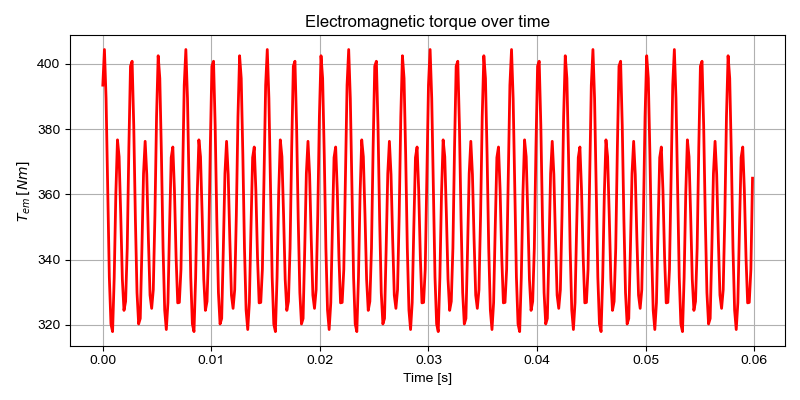

In [7]:
%matplotlib notebook
out.plot_2D_Data("mag.Tem", "time")

To plot only one period or anti-period:

<IPython.core.display.Javascript object>


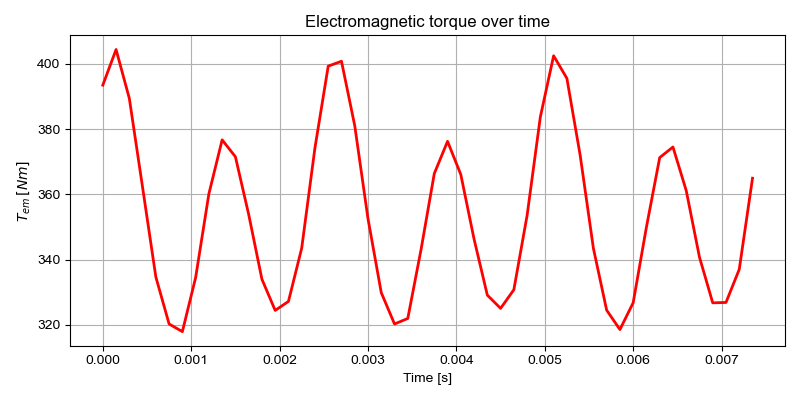

In [8]:
out.plot_2D_Data("mag.Tem", "time[smallestperiod]")

**pyleecan** also has `VectorField` objects for fields with several components, such as the air-gap flux density **B**. The plot command allows to plot all components:

<IPython.core.display.Javascript object>


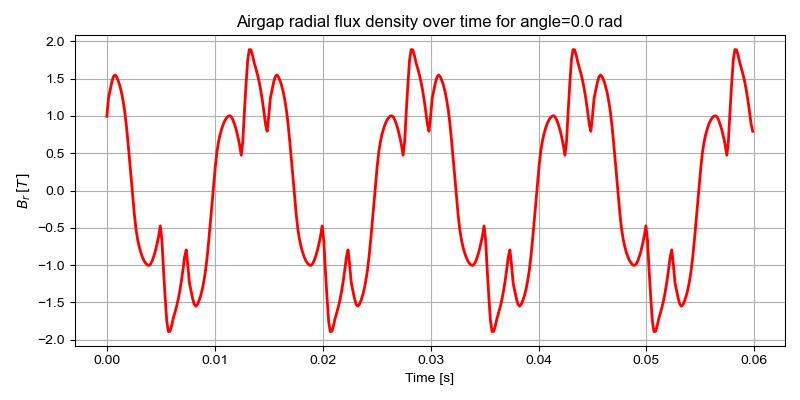

<IPython.core.display.Javascript object>


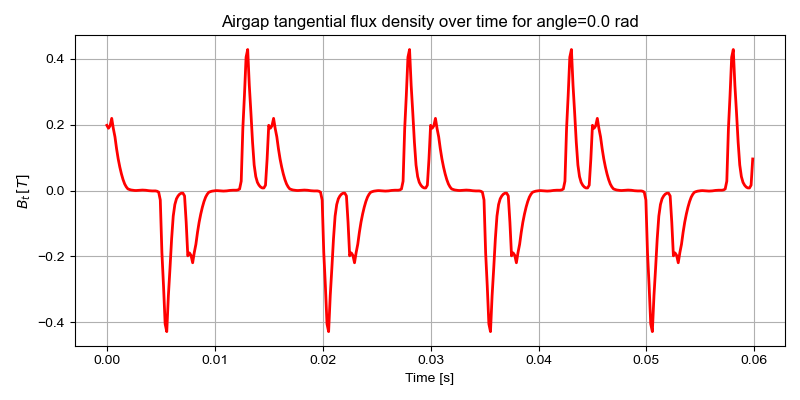

In [9]:
out.plot_2D_Data("mag.B", "time")

To plot only one or several specific components, one can use the `component_list` parameter:

<IPython.core.display.Javascript object>


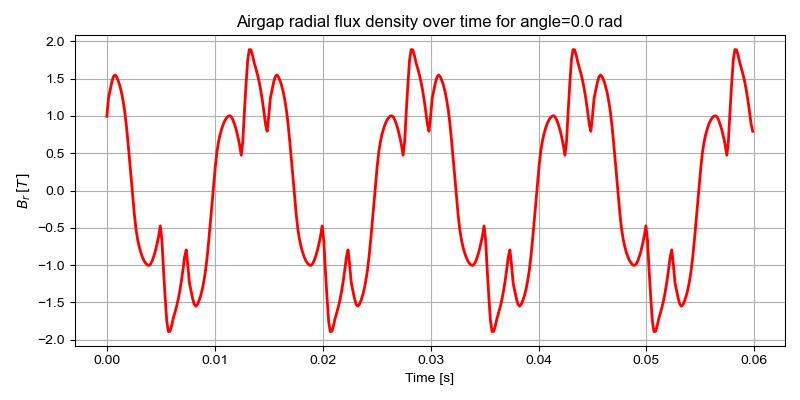

In [10]:
out.plot_2D_Data("mag.B", "time", component_list=["radial"])

## 4) How to slice data

**SciDataTool** also allows to slice along a specific axis, and for specific indices or values. The same feature is also available in the plot commands.

For example, in the last plot, $B_r$ was sliced at `angle[0]` (slice by default), but we could want to slice at another angle:

<IPython.core.display.Javascript object>


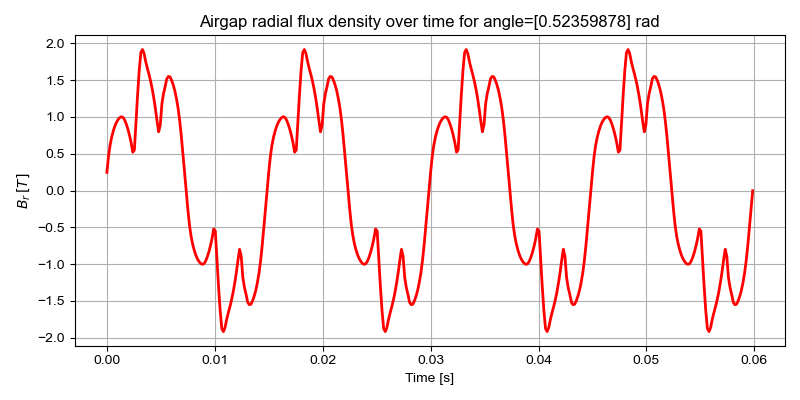

In [11]:
out.plot_2D_Data("mag.B", "time", "angle=pi/6", component_list=["radial"])

We can even superimpose several slices:

<IPython.core.display.Javascript object>


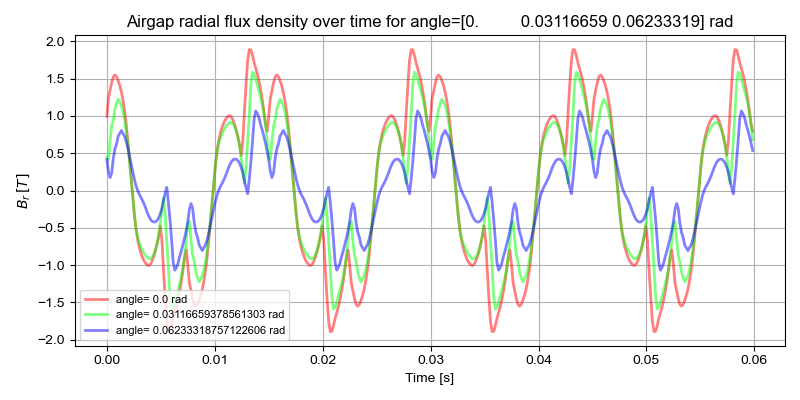

In [12]:
out.plot_2D_Data("mag.B", "time", "angle[0,10,20]", component_list=["radial"])

## 5) How to compute and plot Fourier Transforms

One of the main interest of **SciDataTool** is to hide the complexity of Fourier Transforms. To demonstrate this feature, let us try to compute and plot the fft of the torque manually, and then using **SciDataTool** methods.

- manually:

<IPython.core.display.Javascript object>


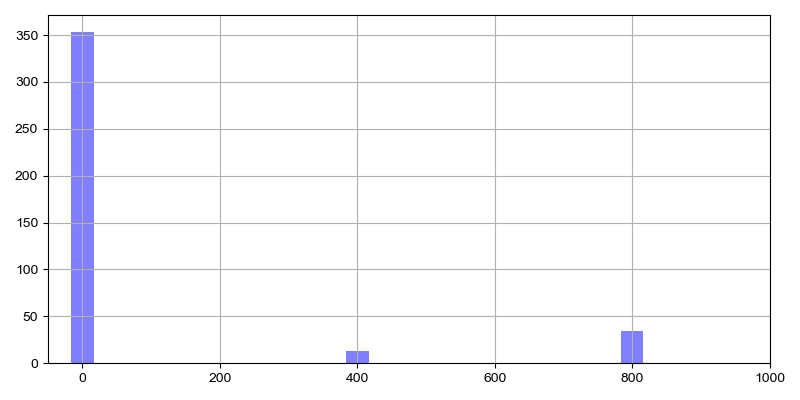

In [13]:
# Extract raw data
Tem_raw = out.mag.Tem.values
t0 = out.mag.Time.initial
tf = out.mag.Time.final
Nt_tot = out.mag.Time.number

# Reconstruct data
time_vector = np.linspace(t0, tf, Nt_tot, endpoint=False)
Tem_array = np.tile(Tem_raw, 8)

# Compute fft
Tem_FT = np.fft.fft(Tem_array)
Tem_FT[0] = Tem_FT[0] * 0.5
Tem_FT = 2 * np.fft.fftshift(Tem_FT) / Nt_tot
Tem_FT_mag = np.abs(Tem_FT)

# Compute freqs
timestep = float(time_vector[1] - time_vector[0])  # Sample step
fsampt = 1.0 / timestep  # Sample frequency
freqscale = Nt_tot / fsampt
freqs = [i - int(Nt_tot / 2) for i in range(int(Nt_tot))]
freqs = np.array([i / freqscale for i in freqs])

# Plot results
from pyleecan.Functions.Plot.plot_2D import plot_2D
%matplotlib notebook
plot_2D([freqs], [Tem_FT_mag], type_plot="bargraph", x_min=-50, x_max=1000)

- using **SciDataTool** methods and **pyleecan** plot commands:

{'freqs': array([  0.        , 133.33333333, 266.66666667, 400.        ,
       533.33333333, 666.66666667, 800.        , 933.33333333]), 'T_{em}': array([3.53693493e+02, 1.54124671e-01, 2.99951582e-01, 1.32720128e+01,
       4.65159617e-01, 2.73747196e-01, 3.41464104e+01, 3.58573830e-01]), 'axes_list': [<SciDataTool.Classes.RequestedAxis.RequestedAxis object at 0x00000263418A2C48>], 'axes_dict_other': {}}


<IPython.core.display.Javascript object>


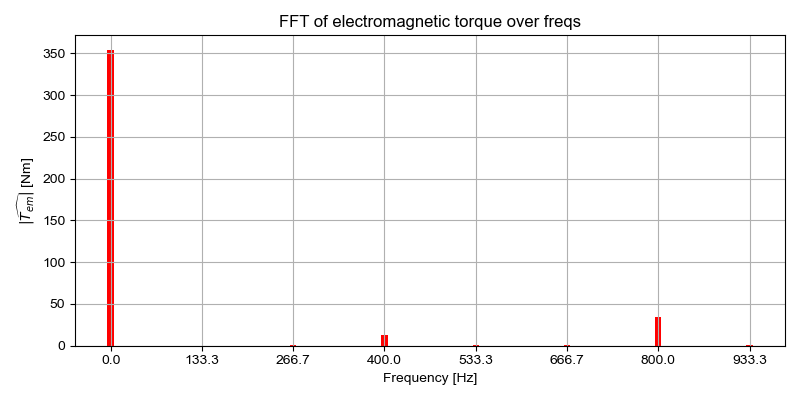

In [14]:
# Equivalent process using SciDataTool
print(out.mag.Tem.get_magnitude_along("freqs=[0,1000]"))

# Plot using generic plot command
out.plot_2D_Data("mag.Tem", "freqs=[0,1000]")

In the case of spatial Fourier Transform, the fundamental is automatically detected from the machine data:

<IPython.core.display.Javascript object>


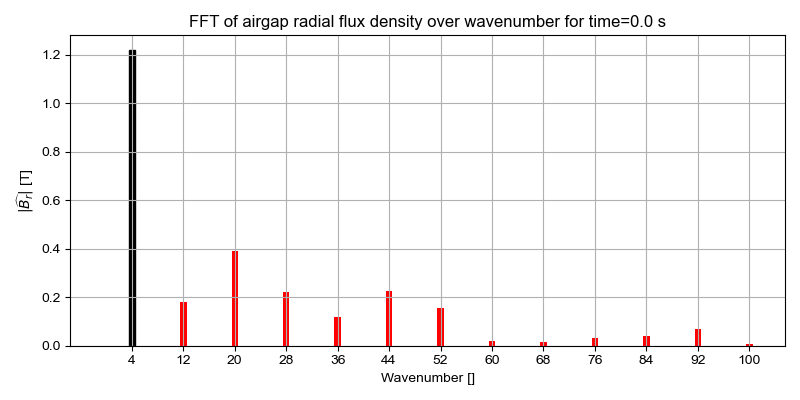

In [16]:
out.plot_2D_Data("mag.B", "wavenumber=[0,100]", component_list=["radial"])

## 6) How to convert or normalize data

Another interesting feature of **SciDataTool** is the conversion feature: **SciDataTool** has built-in methods to convert units, and normalize fields and axes.

For example, we can plot the torque fft in electrical orders:

<IPython.core.display.Javascript object>


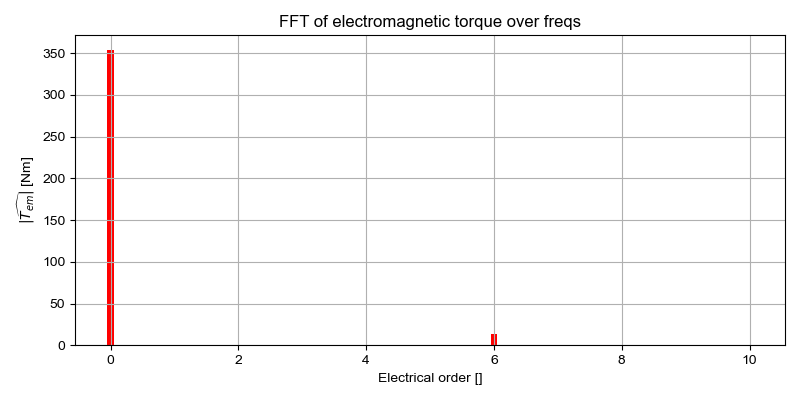

In [17]:
out.plot_2D_Data("mag.Tem", "freqs->elec_order=[0,10]")

In the following example, we will convert the stator winding flux from Webers into Maxwells ($1$ Wb = $10^8$ Mx):

<IPython.core.display.Javascript object>


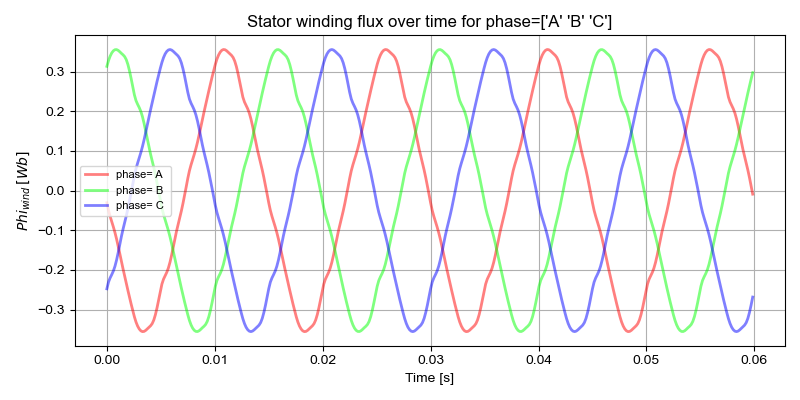

In [18]:
out.plot_2D_Data("mag.Phi_wind_stator", "time", "phase")

<IPython.core.display.Javascript object>


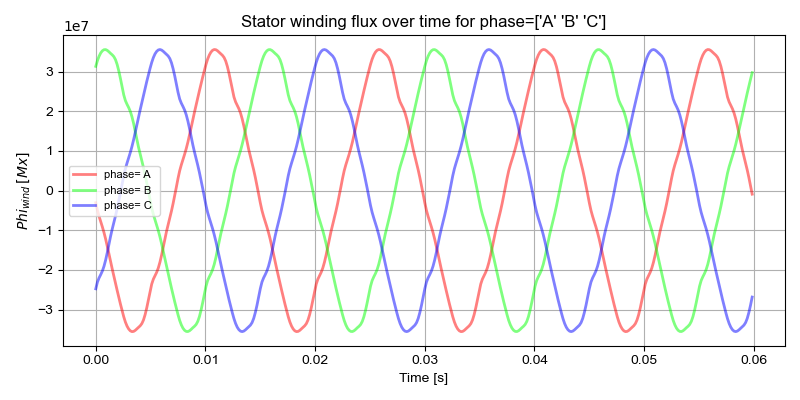

In [19]:
out.plot_2D_Data("mag.Phi_wind_stator", "time", "phase", unit="Mx")

In this last example, we will convert the angle axis into degrees and for the air-gap flux density from Teslas into Gauss ($1$ T= $10^4$ G)

<IPython.core.display.Javascript object>


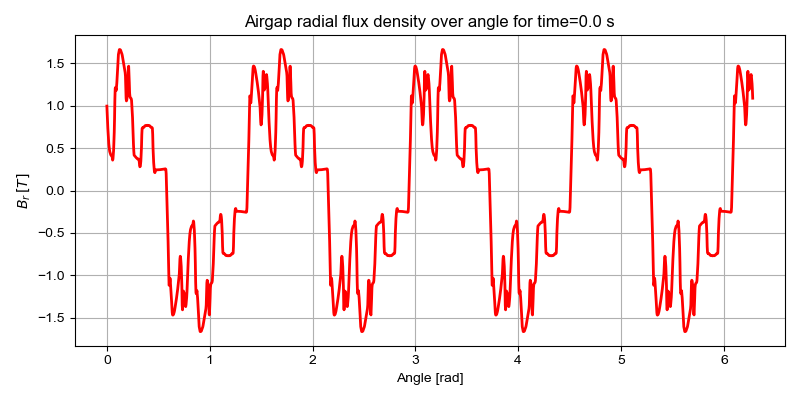

In [20]:
out.plot_2D_Data("mag.B", "angle", component_list=["radial"])

<IPython.core.display.Javascript object>


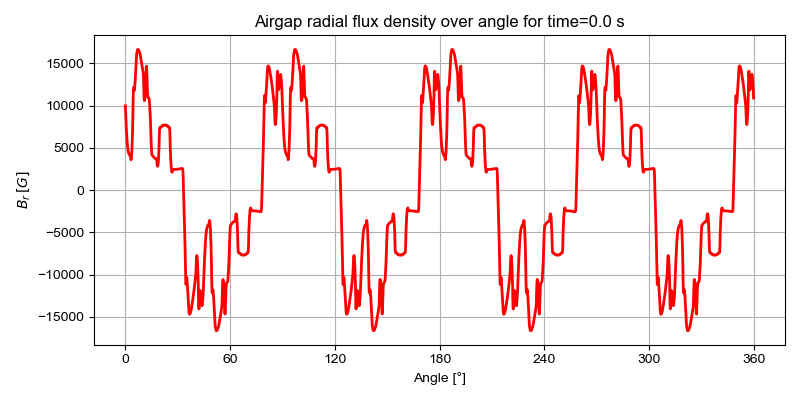

In [21]:
out.plot_2D_Data("mag.B", "angle{°}", component_list=["radial"], unit="G")

The angle can also be converted into distance:

<IPython.core.display.Javascript object>


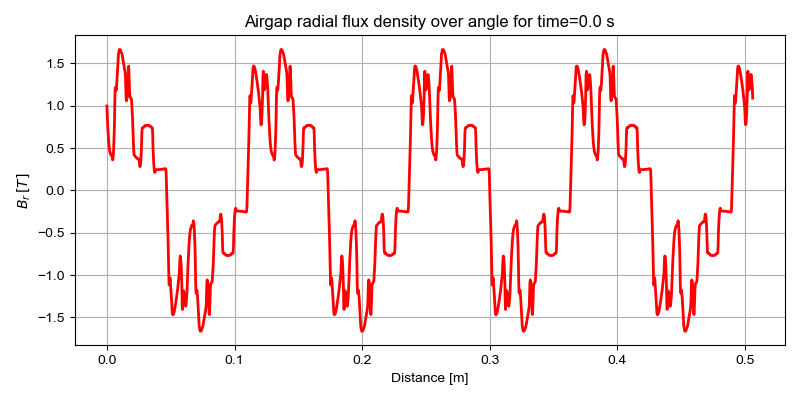

In [22]:
out.plot_2D_Data("mag.B", "angle->distance", component_list=["radial"])

## 7) How to compare data

**SciDataTool** also allows to compare several fields, even if they are defined on different discretizations. To do so, **SciDataTool** has `compare_along` methods, and **pyleecan** plot commands have a `data_list` parameter.

In the folowing example, we compare the torque from the reference simulation, and from the open-circuit one:

<IPython.core.display.Javascript object>


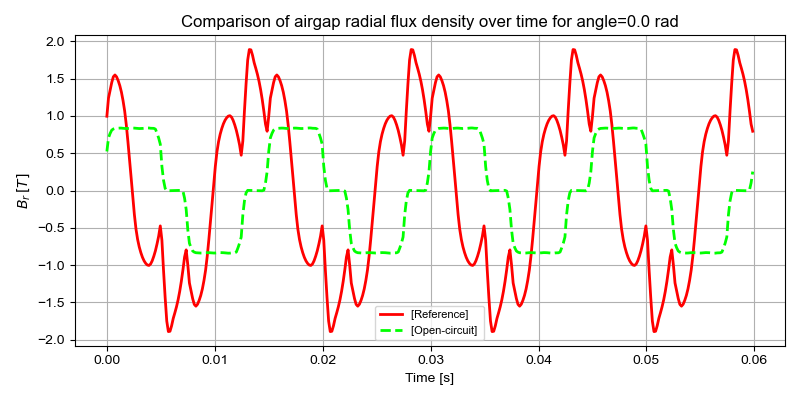

In [23]:
out.plot_2D_Data(
    "mag.B", "time", component_list=["radial"], data_list=[out2.mag.B], legend_list=["Reference", "Open-circuit"]
)

We can also compare fft:

<IPython.core.display.Javascript object>


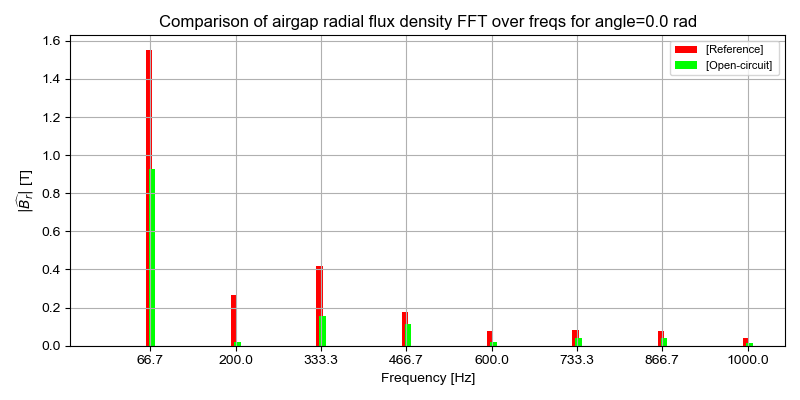

In [24]:
out.plot_2D_Data(
    "mag.B", "freqs=[0,1000]", component_list=["radial"], data_list=[out2.mag.B], legend_list=["Reference", "Open-circuit"]
)

## 8) 3D plots

3D plots (for data defined on at least two axes) can also be created using the `plot_3D_Data` command:

<IPython.core.display.Javascript object>


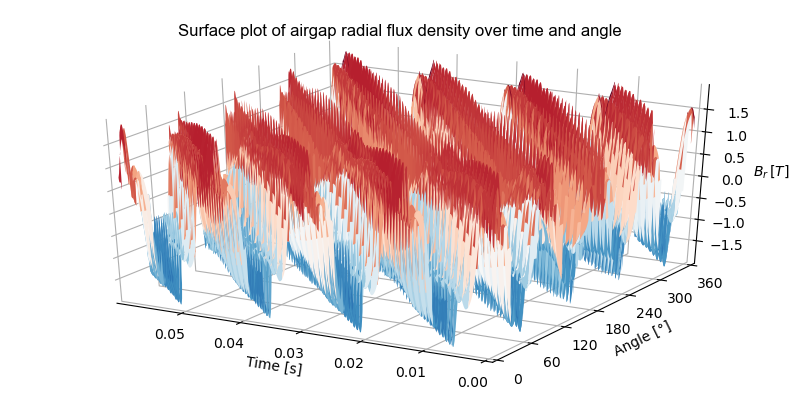

In [25]:
out.plot_3D_Data("mag.B", "time", "angle{°}", component_list=["radial"])

To visualize this surface from above, use `is_2D_view`:

<IPython.core.display.Javascript object>


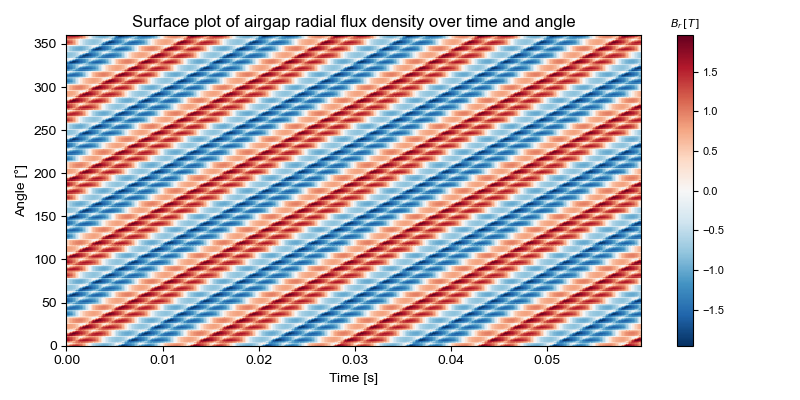

In [26]:
out.plot_3D_Data("mag.B", "time", "angle{°}", component_list=["radial"], is_2D_view=True)

The field is automatically reconstructed using the periodicities specified in the simulation. It is always possible to plot a single period:

<IPython.core.display.Javascript object>


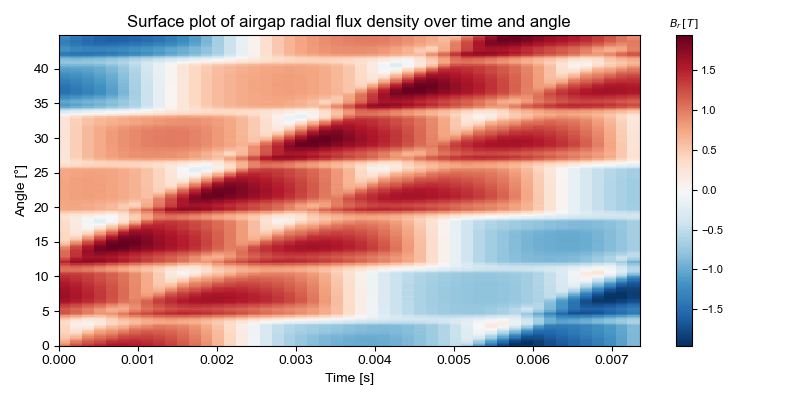

In [27]:
out.plot_3D_Data("mag.B", "time[smallestperiod]", "angle[smallestperiod]{°}", component_list=["radial"], is_2D_view=True)

2D Fourier Transforms also rely on `plot_3D_Data` command:

<IPython.core.display.Javascript object>


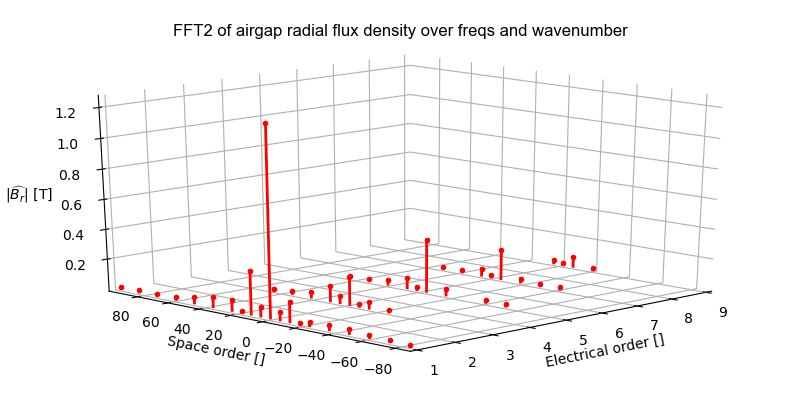

In [28]:
out.plot_3D_Data(
    "mag.B", "freqs->elec_order=[0,10]", "wavenumber->space_order", N_stem=50, component_list=["radial"]
)

It can also be viewed in 2D:

<IPython.core.display.Javascript object>


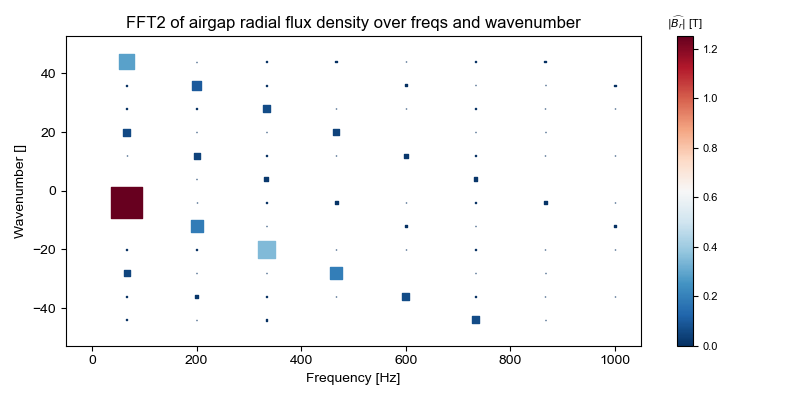

In [29]:
out.plot_3D_Data("mag.B", "freqs=[0,1000]", "wavenumber=[-50,50]", component_list=["radial"], is_2D_view=True)

All these plots were made using the magnetic flux density, but they are of course applicable to any 2D output data, like the force computed using the Maxwell Stress Tensor:

<IPython.core.display.Javascript object>


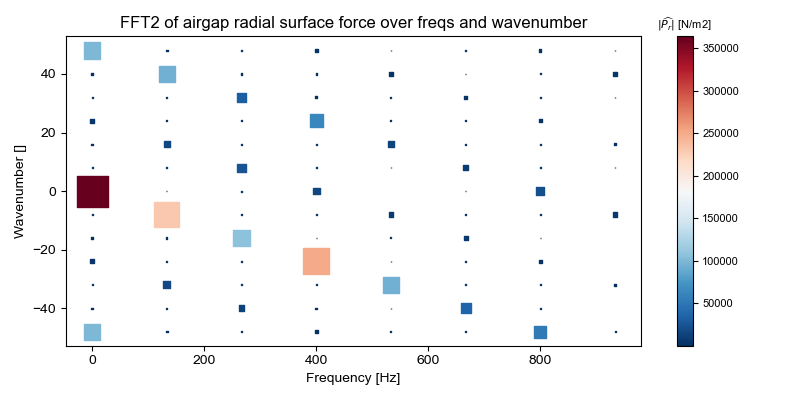

In [30]:
out.plot_3D_Data("force.P", "freqs=[0,1000]", "wavenumber=[-50,50]", component_list=["radial"], is_2D_view=True)